/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.90M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/259k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3448 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/308 [00:00<?, ? examples/s]


DATASET OVERVIEW
Train samples: 3448
Test samples: 308
Total columns: 20

Kept columns: ['president', 'interview_question', 'interview_answer', 'question', 'clarity_label', 'evasion_label', 'date', 'year', 'question_length', 'answer_length', 'question_word_count', 'answer_word_count']
Unfiltered data head:
         president                                 interview_question  \
0  Joseph R. Biden  Q. Of the Biden administration. And accused th...   
1  Joseph R. Biden  Q. Of the Biden administration. And accused th...   
2  Joseph R. Biden  Q. No worries. Do you believe the country's sl...   
3  Joseph R. Biden  Q. No worries. Do you believe the country's sl...   
4  Joseph R. Biden  Q. I can imagine. It is evening, I'd like to r...   

                                    interview_answer  \
0  Well, look, first of all, theI am sincere abou...   
1  Well, look, first of all, theI am sincere abou...   
2  Look, I think China has a difficult economic p...   
3  Look, I think China has a

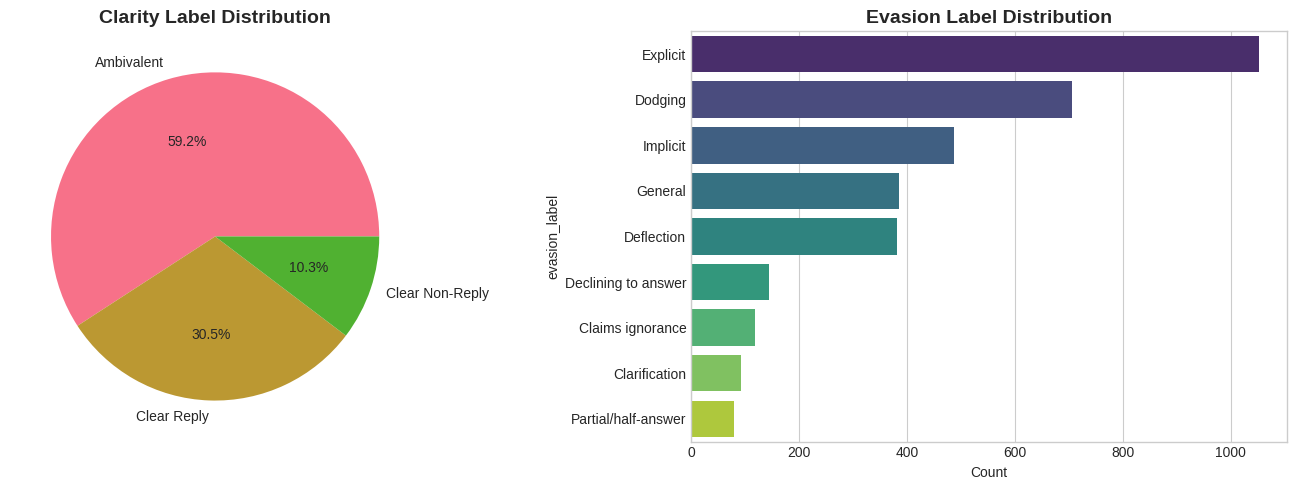

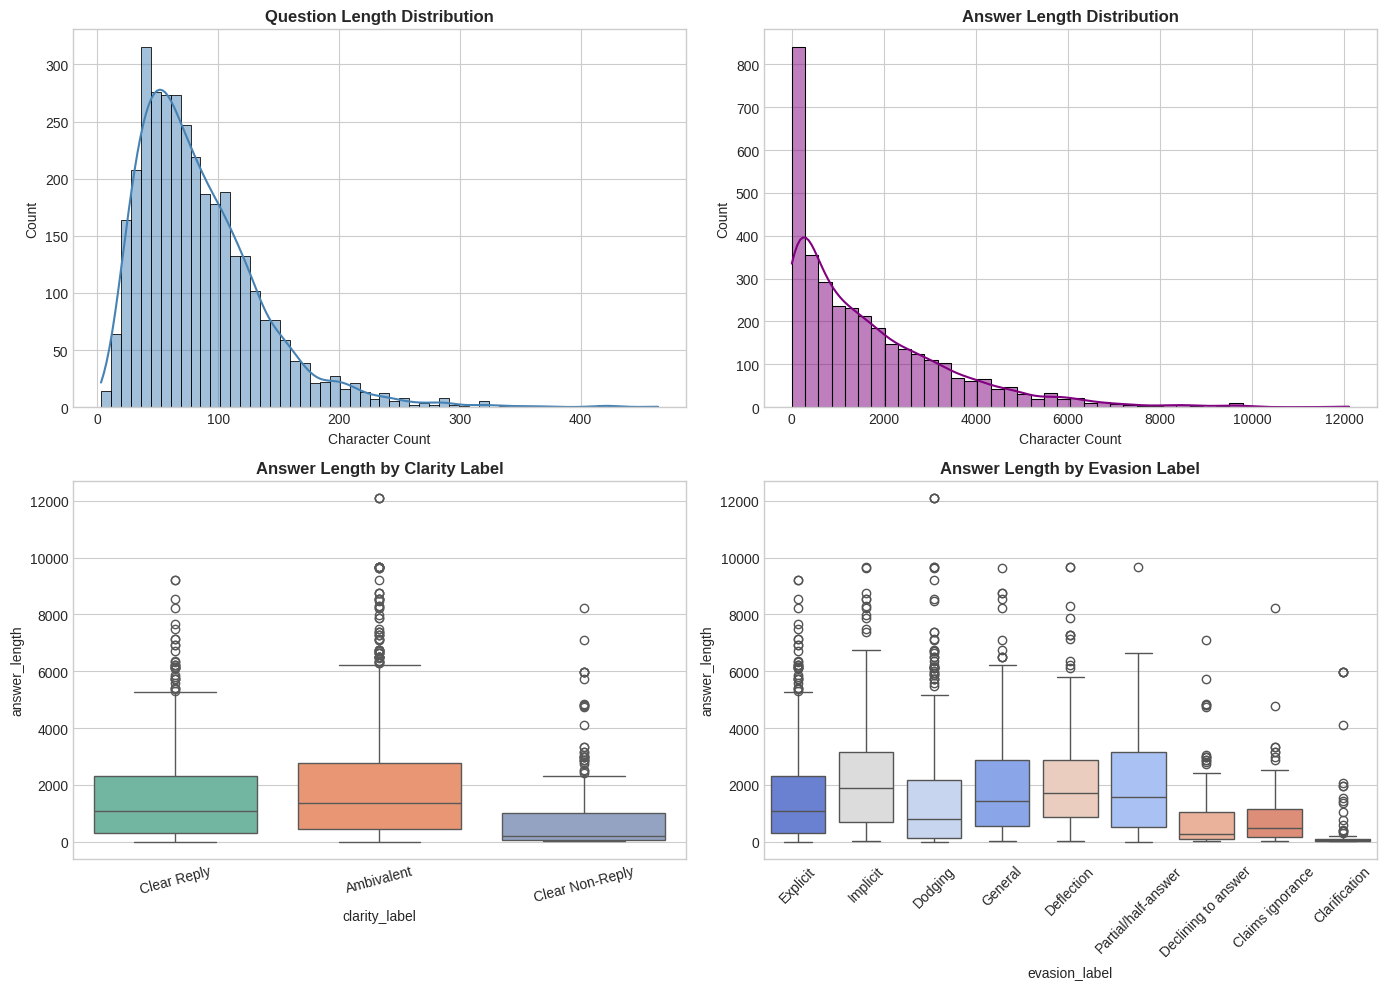

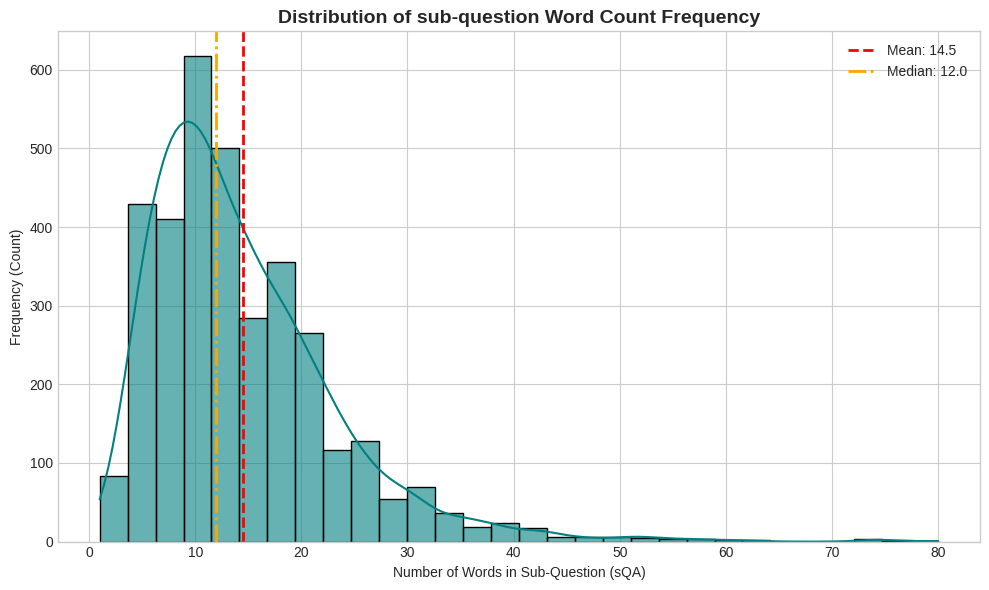

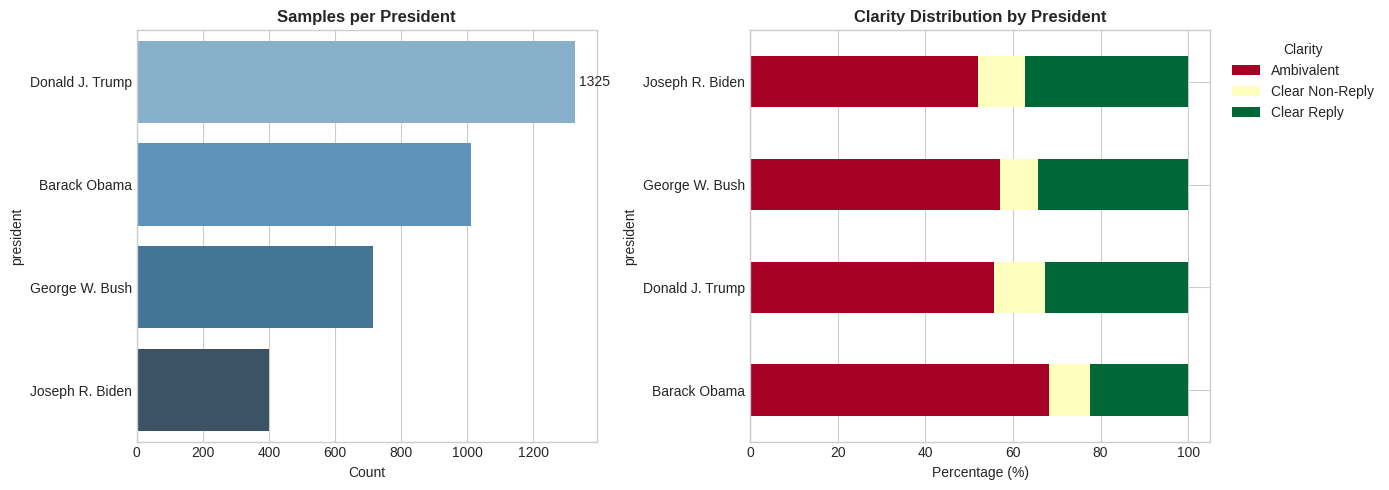

<Figure size 1200x600 with 0 Axes>

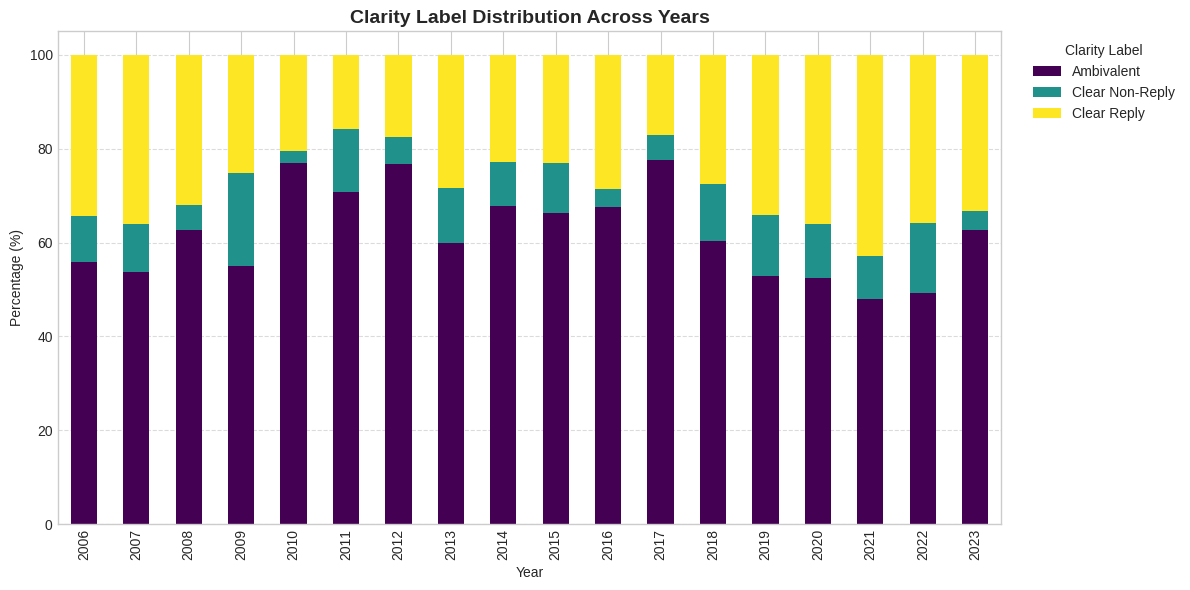

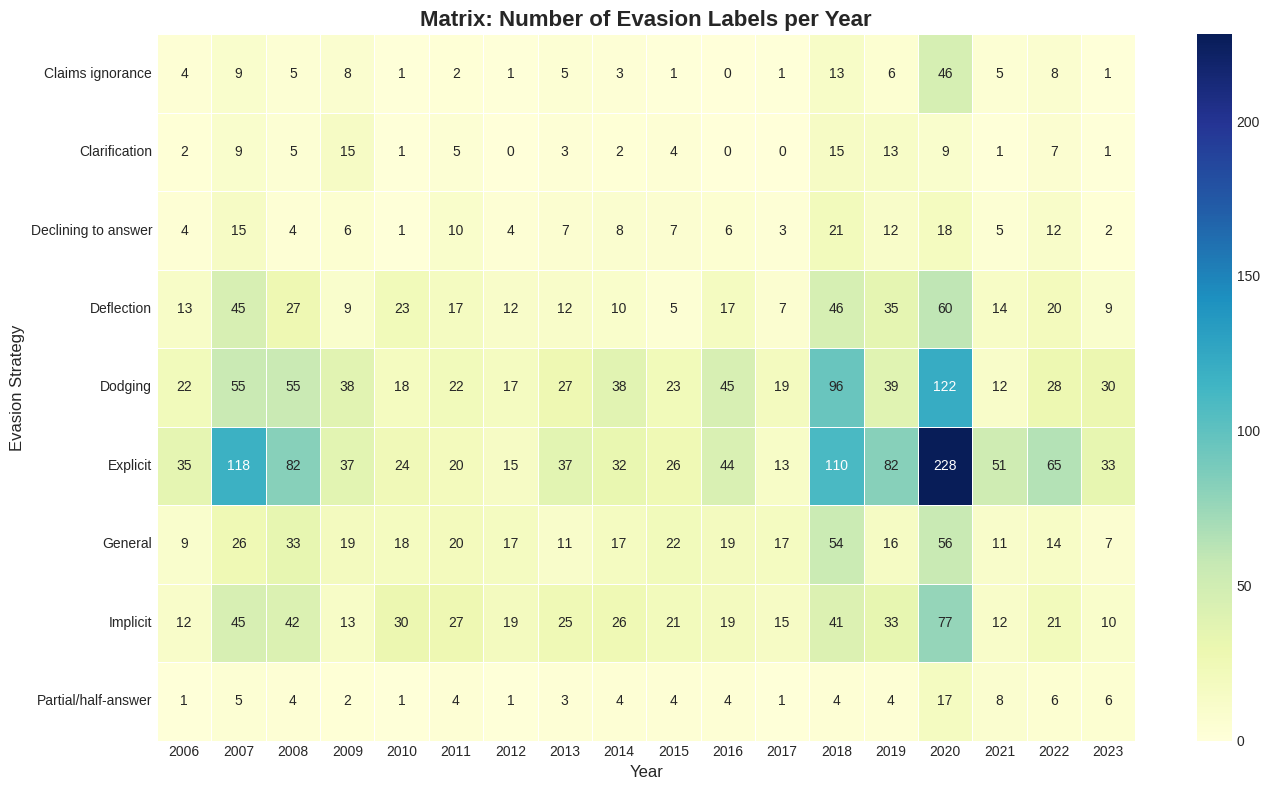

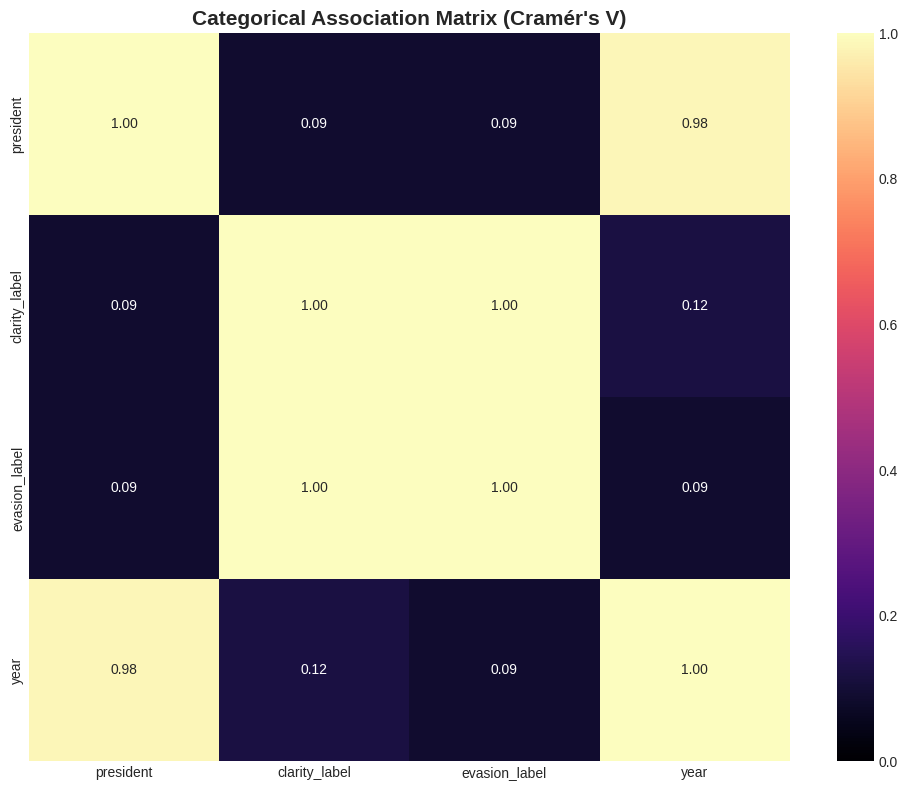

In [1]:
from datasets import load_dataset
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

PLOTS_DIR = Path("plots")

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")


def clean_dataset(df: pd.DataFrame) -> pd.DataFrame:
    columns_to_keep = [
        "president",
        "interview_question",
        "interview_answer",
        "question",
        "clarity_label",
        "evasion_label",
        "date"
    ]
    existing_cols = [col for col in columns_to_keep if col in df.columns]
    return df[existing_cols]

def process_dates(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['year'] = df['date'].dt.year

    if df['year'].isna().any():
        print(f"Warning: {df['year'].isna().sum()} rows had invalid dates and were dropped.")
        df = df.dropna(subset=['year'])

    df['year'] = df['year'].astype(int)
    return df

def add_text_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['question_length'] = df['question'].str.len()
    df['answer_length'] = df['interview_answer'].str.len()
    df['question_word_count'] = df['question'].str.split().str.len()
    df['answer_word_count'] = df['interview_answer'].str.split().str.len()
    return df


def plot_label_distribution(df: pd.DataFrame):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    clarity_counts = df['clarity_label'].value_counts()
    axes[0].pie(clarity_counts, labels=clarity_counts.index, autopct='%1.1f%%')
    axes[0].set_title('Clarity Label Distribution', fontsize=14, fontweight='bold')

    evasion_counts = df['evasion_label'].value_counts()
    sns.barplot(x=evasion_counts.values, y=evasion_counts.index, hue=evasion_counts.index,
                ax=axes[1], palette='viridis', legend=False)
    axes[1].set_xlabel('Count')
    axes[1].set_title('Evasion Label Distribution', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'label_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()


def plot_text_length_analysis(df: pd.DataFrame):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    sns.histplot(df['question_length'], kde=True, ax=axes[0, 0], color='steelblue')
    axes[0, 0].set_title('Question Length Distribution', fontweight='bold')
    axes[0, 0].set_xlabel('Character Count')

    sns.histplot(df['answer_length'], kde=True, ax=axes[0, 1], color='purple')
    axes[0, 1].set_title('Answer Length Distribution', fontweight='bold')
    axes[0, 1].set_xlabel('Character Count')

    sns.boxplot(data=df, x='clarity_label', y='answer_length', hue='clarity_label',
                ax=axes[1, 0], palette='Set2', legend=False)
    axes[1, 0].set_title('Answer Length by Clarity Label', fontweight='bold')
    axes[1, 0].tick_params(axis='x', rotation=15)

    taxonomy_order = [
        'Explicit',
        'Implicit',
        'Dodging',
        'General',
        'Deflection',
        'Partial/half-answer',
        'Declining to answer',
        'Claims ignorance',
        'Clarification',
    ]
    sns.boxplot(data=df, x='evasion_label', y='answer_length', hue='evasion_label',
                ax=axes[1, 1], order=taxonomy_order, palette='coolwarm', legend=False)
    axes[1, 1].set_title('Answer Length by Evasion Label', fontweight='bold')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'text_length_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()


def plot_president_analysis(df: pd.DataFrame):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    pres_counts = df['president'].value_counts()
    sns.barplot(x=pres_counts.values, y=pres_counts.index, hue=pres_counts.index,
                ax=axes[0], palette='Blues_d', legend=False)
    axes[0].set_title('Samples per President', fontweight='bold')
    axes[0].set_xlabel('Count')
    axes[0].bar_label(axes[0].containers[0], padding=3)

    pres_clarity = pd.crosstab(df['president'], df['clarity_label'], normalize='index') * 100
    pres_clarity.plot(kind='barh', stacked=True, ax=axes[1], colormap='RdYlGn')
    axes[1].set_title('Clarity Distribution by President', fontweight='bold')
    axes[1].set_xlabel('Percentage (%)')
    axes[1].legend(title='Clarity', bbox_to_anchor=(1.02, 1))

    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'president_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()


def plot_label_evolution_by_year(df: pd.DataFrame):
    plt.figure(figsize=(12, 6))

    year_clarity = pd.crosstab(df['year'], df['clarity_label'], normalize='index') * 100

    ax = year_clarity.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))

    plt.title('Clarity Label Distribution Across Years', fontsize=14, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Percentage (%)')
    plt.legend(title='Clarity Label', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'label_distribution_years.png', dpi=150, bbox_inches='tight')
    plt.show()

def plot_evasion_year_matrix(df: pd.DataFrame):
    plt.figure(figsize=(14, 8))

    evasion_year_matrix = pd.crosstab(df['evasion_label'], df['year'])

    sns.heatmap(evasion_year_matrix, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5)

    plt.title('Matrix: Number of Evasion Labels per Year', fontsize=16, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Evasion Strategy', fontsize=12)
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'evasion_year_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

def plot_sqa_length_distribution(df: pd.DataFrame):
    plt.figure(figsize=(10, 6))

    sns.histplot(df['question_word_count'], kde=True, bins=30, color='teal', alpha=0.6, edgecolor='black')

    mean_len = df['question_word_count'].mean()
    median_len = df['question_word_count'].median()

    plt.axvline(mean_len, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_len:.1f}')
    plt.axvline(median_len, color='orange', linestyle='-.', linewidth=2, label=f'Median: {median_len:.1f}')

    plt.title('Distribution of sub-question Word Count Frequency', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Words in Sub-Question (sQA)')
    plt.ylabel('Frequency (Count)')
    plt.legend()

    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'sqa_length_frequency.png', dpi=150, bbox_inches='tight')
    plt.show()

def print_summary_statistics(df: pd.DataFrame):
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    numeric_cols = ['question_length', 'answer_length', 'question_word_count', 'answer_word_count']
    print(df[numeric_cols].describe().round(2))

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    with np.errstate(divide='ignore', invalid='ignore'):
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        if min((kcorr-1), (rcorr-1)) == 0:
            return 0.0
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def plot_association_heatmap(df):
    cols = ['president', 'clarity_label', 'evasion_label', 'year']

    corr_matrix = pd.DataFrame(index=cols, columns=cols)

    for c1 in cols:
        for c2 in cols:
            if c1 == c2:
                corr_matrix.loc[c1, c2] = 1.0
            else:
                val = cramers_v(df[c1], df[c2])
                corr_matrix.loc[c1, c2] = val

    corr_matrix = corr_matrix.astype(float)

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='magma', vmin=0, vmax=1)
    plt.title("Categorical Association Matrix (Cramér's V)", fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    PLOTS_DIR.mkdir(exist_ok=True)

    dataset = load_dataset("ailsntua/QEvasion")
    df_train = dataset["train"].to_pandas()
    df_test = dataset["test"].to_pandas()

    print(f"\n{'='*60}")
    print("DATASET OVERVIEW")

    print("="*60)
    print(f"Train samples: {len(df_train)}")
    print(f"Test samples: {len(df_test)}")
    print(f"Total columns: {len(df_train.columns)}")

    df = clean_dataset(df_train)

    df = process_dates(df)

    df = add_text_features(df)

    print(f"\nKept columns: {list(df.columns)}")

    print(f"Unfiltered data head:\n{df.head()}\n")

    print_summary_statistics(df)

    print(f"\n{'='*60}")
    print("LABEL DISTRIBUTIONS")
    print("="*60)
    print("\nClarity Labels:")
    print(df['clarity_label'].value_counts())
    print("\nEvasion Labels:")
    print(df['evasion_label'].value_counts())


    plot_label_distribution(df)
    plot_text_length_analysis(df)
    plot_sqa_length_distribution(df)

    plot_president_analysis(df)

    plot_label_evolution_by_year(df)
    plot_evasion_year_matrix(df)

    plot_association_heatmap(df)
